#  Airline Delay Analysis — EDA + Machine Learning

###  Objective
The goal of this project is to:
1. Analyze the causes and patterns of flight delays.
2. Build regression models to predict *delay duration (minutes)*.
3. Build classification models to predict whether a flight will be *delayed (>15 min)*.
4. Apply data preprocessing, visualization, and model optimization techniques.

This notebook follows a structured ML workflow:
- **Data Loading & Cleaning**
- **Exploratory Data Analysis (EDA)**
- **Feature Engineering**
- **Regression & Classification Modeling**
- **Hyperparameter Tuning**
- **Insights & Conclusion**

###  Step 1: Import and Load Data
We import all necessary Python libraries for data analysis, visualization, and machine learning.
Then we load the flight dataset and inspect its size and sample rows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay,
    mean_squared_error, r2_score
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

RANDOM_STATE = 42
pd.set_option("display.max_columns", 200)

DATA_PATH = "DelayedFlights.csv"   # update path if needed
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Raw shape:", df.shape)

# 💡 Reduce dataset size to avoid memory crash
df_small = df.sample(50000, random_state=RANDOM_STATE)
df = df_small  # Rename back to df so rest of the code still works
print("Sampled dataset shape:", df.shape)

# View first few rows
df.head(3)

Raw shape: (1936758, 30)
Sampled dataset shape: (50000, 30)


,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1782417,6583804,2008,12,6,6,1805.0,1755,2146.0,2035,YV,7281,N505MJ,281.0,220.0,177.0,71.0,10.0,IAD,AUS,1297,5.0,99.0,0,N,0,71.0,0.0,0.0,0.0,0.0
512712,1604365,2008,3,23,7,2120.0,1200,2241.0,1333,NW,131,N777NC,81.0,93.0,55.0,548.0,560.0,ORD,MSP,334,7.0,19.0,0,N,0,543.0,0.0,0.0,0.0,5.0
447137,1395655,2008,3,31,1,1731.0,1710,1819.0,1810,OO,3676,N224SW,48.0,60.0,44.0,9.0,21.0,SLC,PIH,150,3.0,1.0,0,N,0,NaN,NaN,NaN,NaN,NaN


##  Chunk 2 – Data Cleaning and Feature Preparation

This section cleans the dataset and prepares it for analysis and modeling.

**Objectives:**
1. Remove unnecessary columns (like `Unnamed: 0`).
2. Standardize column names for easier use.
3. Create a proper `FL_DATE` (Flight Date) and `CRS_DEP_HOUR` (scheduled departure hour).
4. Remove duplicate rows.
5. Handle missing values:
   - Fill `NaN` in numeric columns with median.
   - Fill `NaN` in categorical columns with mode.
   - Fill missing delay causes (CarrierDelay, WeatherDelay, etc.) with 0.
6. Drop rows with missing target (`ArrDelay`).
7. Clip extreme outliers in delays for visualization.
8. Create a binary label `Delayed_15` for classification models.

In [7]:
# ===== CHUNK 2 : DATA CLEANING =====

import pandas as pd
import numpy as np

# 1️ Drop unnecessary columns
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

# 2️ Standardize column names
df.rename(columns={
    "Year": "YEAR",
    "Month": "MONTH",
    "DayofMonth": "DAY_OF_MONTH",
    "DayOfWeek": "DAY_OF_WEEK",
    "CRSDepTime": "CRS_DEP_TIME",
    "DepTime": "DEP_TIME",
    "CRSArrTime": "CRS_ARR_TIME",
    "ArrTime": "ARR_TIME",
    "UniqueCarrier": "UNIQUE_CARRIER",
    "FlightNum": "FL_NUM",
    "TailNum": "TAIL_NUM",
    "ArrDelay": "ARR_DELAY",
    "DepDelay": "DEP_DELAY",
    "CRSElapsedTime": "CRS_ELAPSED_TIME",
    "ActualElapsedTime": "ACTUAL_ELAPSED_TIME",
    "AirTime": "AIR_TIME",
    "TaxiIn": "TAXI_IN",
    "TaxiOut": "TAXI_OUT",
    "Cancelled": "CANCELLED",
    "CancellationCode": "CANCELLATION_CODE",
    "Diverted": "DIVERTED",
    "CarrierDelay": "CARRIER_DELAY",
    "WeatherDelay": "WEATHER_DELAY",
    "NASDelay": "NAS_DELAY",
    "SecurityDelay": "SECURITY_DELAY",
    "LateAircraftDelay": "LATE_AIRCRAFT_DELAY"
}, inplace=True)

# 3️ Create flight date and departure hour
if {"YEAR","MONTH","DAY_OF_MONTH"}.issubset(df.columns):
    df["FL_DATE"] = pd.to_datetime(dict(year=df.YEAR, month=df.MONTH, day=df.DAY_OF_MONTH), errors="coerce")

if "CRS_DEP_TIME" in df.columns:
    df["CRS_DEP_HOUR"] = (df["CRS_DEP_TIME"] // 100).astype("Int64")

# 4️ Remove duplicate rows
before = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Removed {before - df.shape[0]} duplicate rows")

# 5️ Handle missing values (safe version – no warnings)

# Drop rows where target ARR_DELAY is missing
df = df[~df["ARR_DELAY"].isna()].copy()

# Fill delay-cause columns with 0 (no delay = 0)
cause_cols = ["CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]
for c in cause_cols:
    if c in df.columns:
        df[c] = df[c].fillna(0)

# Fill numeric columns (except target) with median
num_cols = df.select_dtypes(include=np.number).columns.tolist()
if "ARR_DELAY" in num_cols:
    num_cols.remove("ARR_DELAY")
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

# Fill categorical columns with mode
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode(dropna=True).iloc[0])

print(" Missing values handled successfully!")
print(df.isna().sum().sort_values(ascending=False).head(10))

print("\nRemaining missing values (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))

# 6️ Clip extreme delay values (for visualization only)
df["ARR_DELAY_CLIPPED"] = df["ARR_DELAY"].clip(lower=-60, upper=300)

# 7️ Create binary classification target: Delayed (>15 mins)
df["Delayed_15"] = (df["ARR_DELAY"] > 15).astype("int8")

print("\n Data cleaning complete!")
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
df.head(3)

Removed 0 duplicate rows
 Missing values handled successfully!
YEAR                   0
Dest                   0
ARR_DELAY_CLIPPED      0
CRS_DEP_HOUR           0
FL_DATE                0
LATE_AIRCRAFT_DELAY    0
SECURITY_DELAY         0
NAS_DELAY              0
WEATHER_DELAY          0
CARRIER_DELAY          0
dtype: int64

Remaining missing values (top 10):
YEAR                   0
Dest                   0
ARR_DELAY_CLIPPED      0
CRS_DEP_HOUR           0
FL_DATE                0
LATE_AIRCRAFT_DELAY    0
SECURITY_DELAY         0
NAS_DELAY              0
WEATHER_DELAY          0
CARRIER_DELAY          0
dtype: int64

 Data cleaning complete!
Rows: 49791
Columns: 33


,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,CRS_DEP_TIME,ARR_TIME,CRS_ARR_TIME,UNIQUE_CARRIER,FL_NUM,TAIL_NUM,ACTUAL_ELAPSED_TIME,CRS_ELAPSED_TIME,AIR_TIME,ARR_DELAY,DEP_DELAY,Origin,Dest,Distance,TAXI_IN,TAXI_OUT,CANCELLED,CANCELLATION_CODE,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FL_DATE,CRS_DEP_HOUR,ARR_DELAY_CLIPPED,Delayed_15
1782417,2008,12,6,6,1805.0,1755,2146.0,2035,YV,7281,N505MJ,281.0,220.0,177.0,71.0,10.0,IAD,AUS,1297,5.0,99.0,0,N,0,71.0,0.0,0.0,0.0,0.0,2008-12-06,17,71.0,1
512712,2008,3,23,7,2120.0,1200,2241.0,1333,NW,131,N777NC,81.0,93.0,55.0,548.0,560.0,ORD,MSP,334,7.0,19.0,0,N,0,543.0,0.0,0.0,0.0,5.0,2008-03-23,12,300.0,1
447137,2008,3,31,1,1731.0,1710,1819.0,1810,OO,3676,N224SW,48.0,60.0,44.0,9.0,21.0,SLC,PIH,150,3.0,1.0,0,N,0,0.0,0.0,0.0,0.0,0.0,2008-03-31,17,9.0,0


##  Chunk 3 — Exploratory Data Analysis (EDA)

**Goal:** Understand delay patterns so we know which features matter.

We’ll:
1) Check class balance (`Delayed_15`)
2) Look at delay distribution
3) See average delays by Month / Day-of-Week / Hour
4) Compare airlines (UniqueCarrier)
5) Inspect delay causes
6) Check relationship of Distance with delays

Class balance:
Delayed_15
>15 min delayed    31379
On-time/<=15       18412
Name: count, dtype: int64


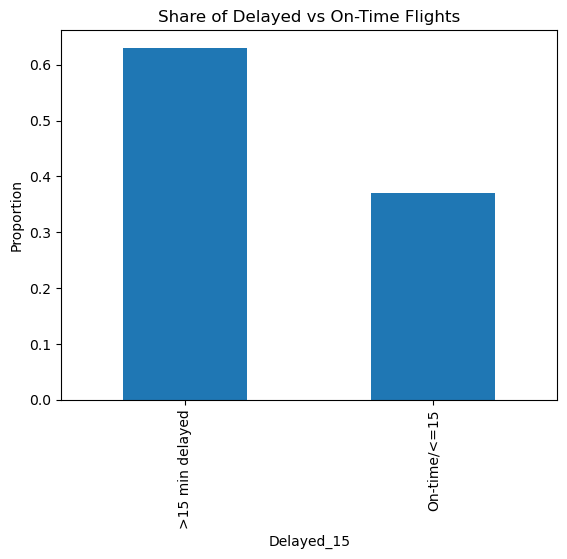

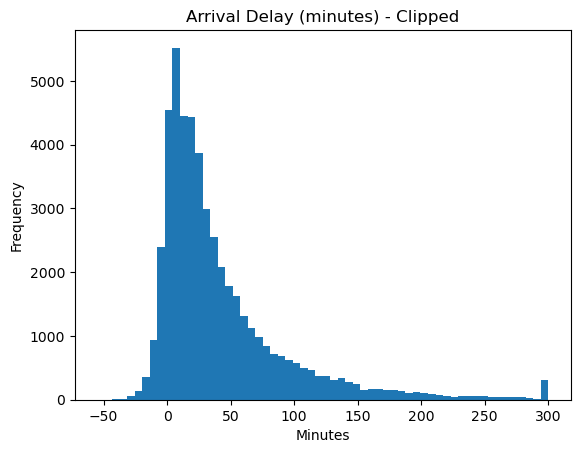

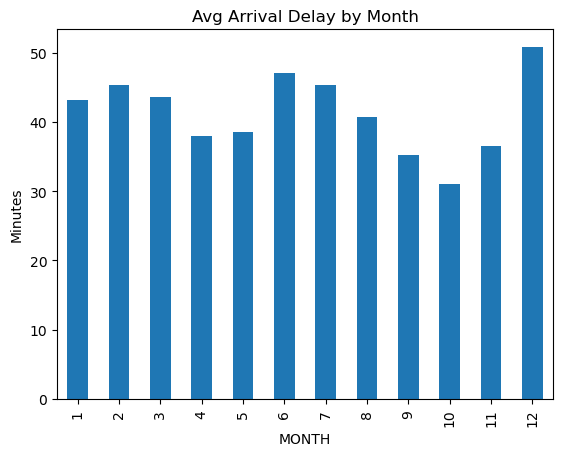

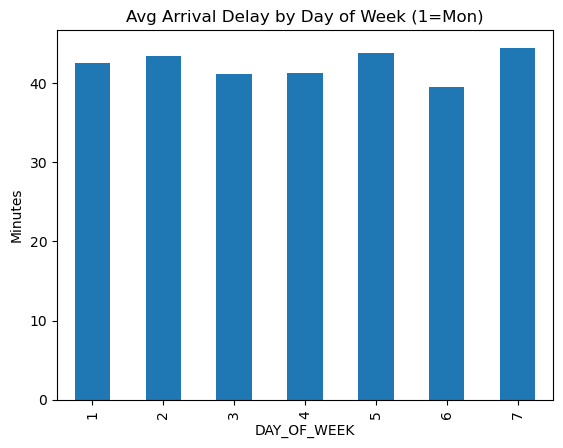

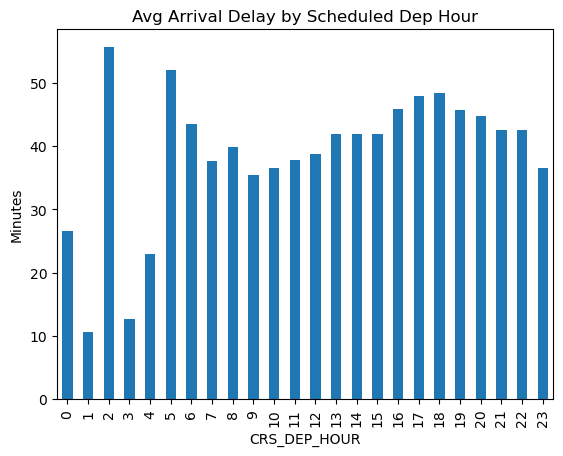

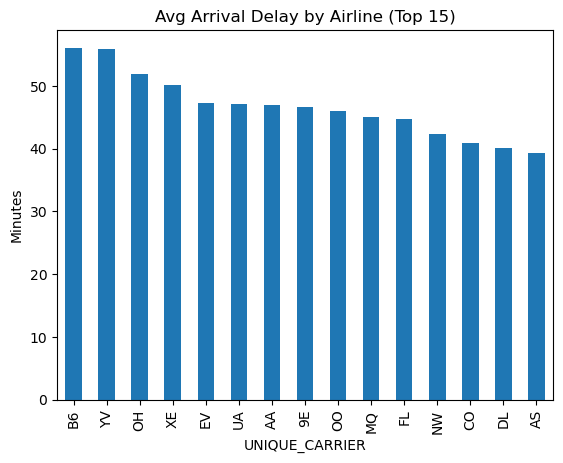

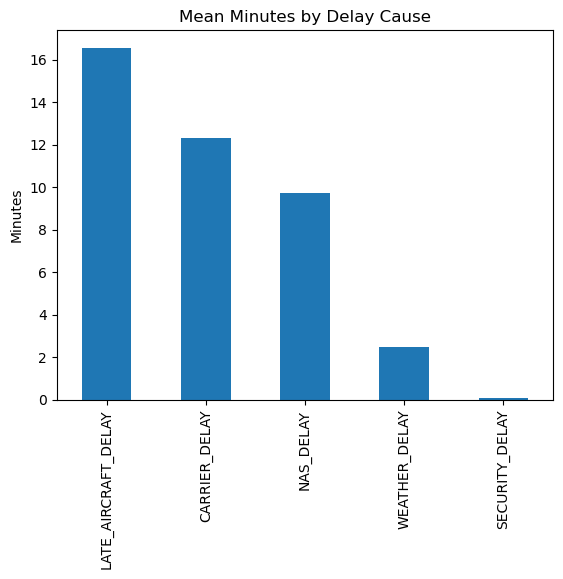

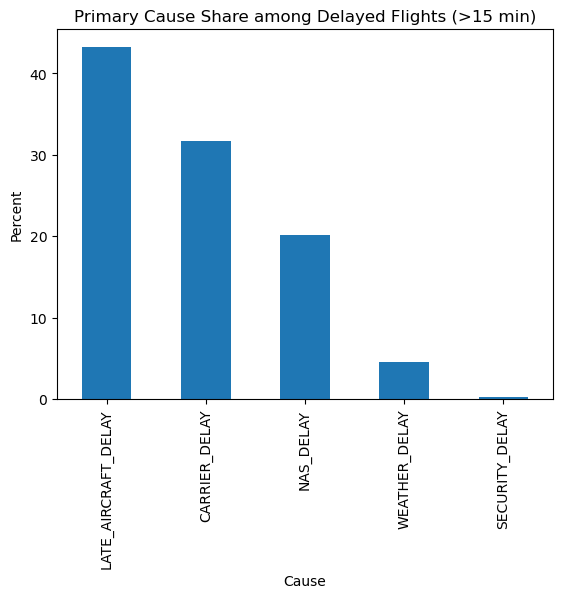

Numeric correlation (subset):
                     ARR_DELAY  DEP_DELAY  CRS_ELAPSED_TIME  \
ARR_DELAY                 1.00       0.95             -0.02   
DEP_DELAY                 0.95       1.00              0.00   
CRS_ELAPSED_TIME         -0.02       0.00              1.00   
ACTUAL_ELAPSED_TIME       0.07       0.01              0.97   
AIR_TIME                 -0.00      -0.01              0.99   
TAXI_OUT                  0.29       0.08              0.13   
TAXI_IN                   0.16       0.07              0.09   

                     ACTUAL_ELAPSED_TIME  AIR_TIME  TAXI_OUT  TAXI_IN  
ARR_DELAY                           0.07     -0.00      0.29     0.16  
DEP_DELAY                           0.01     -0.01      0.08     0.07  
CRS_ELAPSED_TIME                    0.97      0.99      0.13     0.09  
ACTUAL_ELAPSED_TIME                 1.00      0.98      0.30     0.16  
AIR_TIME                            0.98      1.00      0.10     0.08  
TAXI_OUT                         

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Class balance (delayed vs not delayed)
if "Delayed_15" in df.columns:
    cls_counts = df["Delayed_15"].value_counts().rename({0:"On-time/<=15",1:">15 min delayed"})
    print("Class balance:")
    print(cls_counts)
    (cls_counts / cls_counts.sum()).plot(kind="bar", title="Share of Delayed vs On-Time Flights")
    plt.ylabel("Proportion")
    plt.show()

# 2) Delay distribution
df["ARR_DELAY_CLIPPED"].plot(kind="hist", bins=60, title="Arrival Delay (minutes) - Clipped")
plt.xlabel("Minutes")
plt.show()

# 3) Time patterns
if "MONTH" in df.columns:
    df.groupby("MONTH")["ARR_DELAY"].mean().plot(kind="bar", title="Avg Arrival Delay by Month")
    plt.ylabel("Minutes"); plt.show()

if "DAY_OF_WEEK" in df.columns:
    df.groupby("DAY_OF_WEEK")["ARR_DELAY"].mean().plot(kind="bar", title="Avg Arrival Delay by Day of Week (1=Mon)")
    plt.ylabel("Minutes"); plt.show()

if "CRS_DEP_HOUR" in df.columns:
    df.groupby("CRS_DEP_HOUR")["ARR_DELAY"].mean().plot(kind="bar", title="Avg Arrival Delay by Scheduled Dep Hour")
    plt.ylabel("Minutes"); plt.show()

# 4) Airlines
if "UNIQUE_CARRIER" in df.columns:
    (df.groupby("UNIQUE_CARRIER")["ARR_DELAY"].mean()
       .sort_values(ascending=False)
       .head(15)
       .plot(kind="bar", title="Avg Arrival Delay by Airline (Top 15)"))
    plt.ylabel("Minutes"); plt.show()

# 5) Delay causes (mean minutes)
cause_cols = ["CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]
avail_causes = [c for c in cause_cols if c in df.columns]
if avail_causes:
    df[avail_causes].mean().sort_values(ascending=False).plot(kind="bar", title="Mean Minutes by Delay Cause")
    plt.ylabel("Minutes"); plt.show()

    # Share of primary cause among delayed flights (>15 min)
    delayed = df[df["ARR_DELAY"] > 15].copy()
    if not delayed.empty:
        primary = delayed[avail_causes].idxmax(axis=1)
        (primary.value_counts(normalize=True)
               .rename_axis("Cause")
               .mul(100)
               .round(1)
               .plot(kind="bar", title="Primary Cause Share among Delayed Flights (>15 min)"))
        plt.ylabel("Percent"); plt.show()

# 6) Distance vs delay
if "DISTANCE" in df.columns:
    # Use clipped for readability if available
    ycol = "ARR_DELAY_CLIPPED" if "ARR_DELAY_CLIPPED" in df.columns else "ARR_DELAY"
    df.plot.scatter(x="DISTANCE", y=ycol, alpha=0.15, title="Distance vs Arrival Delay")
    plt.show()

# 7) Quick correlation peek for numerics (optional)
num_cols_for_corr = [c for c in ["ARR_DELAY","DEP_DELAY","DISTANCE","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","AIR_TIME","TAXI_OUT","TAXI_IN"] if c in df.columns]
if len(num_cols_for_corr) >= 2:
    corr = df[num_cols_for_corr].corr()
    print("Numeric correlation (subset):")
    
    print(corr.round(2))

##  Exploratory Data Analysis (EDA) Insights

### 1️ Arrival Delay Distribution (Clipped)
- Most flights have **arrival delays close to 0 minutes**, meaning they arrive on time or only slightly late.  
- A small number of flights experience **very high delays (outliers around 300 minutes)**.  
- The distribution is **right-skewed**, showing that long delays are less frequent but still significant.

---

### 2️ Delayed vs On-Time Flights
- Around **63% of flights** are delayed by more than 15 minutes.  
- About **37%** of flights are on-time (delay ≤ 15 min).  
- This imbalance indicates delays are common and may impact airline punctuality and customer satisfaction.

---

### 3️ Correlation Between Numerical Features
- **Arrival Delay (ARR_DELAY)** and **Departure Delay (DEP_DELAY)** have a **very high positive correlation (0.95)** —  
  meaning if a flight departs late, it almost always arrives late too.  
- **Air Time**, **CRS Elapsed Time**, and **Actual Elapsed Time** are also highly correlated (>0.97).  
- Low correlations between delay and taxi times suggest that **delays are more affected by scheduling and operations** rather than ground movement.

---

### 4️ Average Arrival Delay by Month
- **December** shows the **highest average delays (~50 minutes)** — likely due to winter weather and holiday congestion.  
- **October** has the **lowest delays (~30 minutes)**.  
- Seasonal variation indicates external factors (like weather and traffic volume) affect delays.

---

### 5️ Average Arrival Delay by Day of the Week
- Delays are **fairly consistent across all weekdays**, averaging around **40–45 minutes**.  
- Slightly higher delays are seen on **weekends (Saturday/Sunday)** — possibly due to heavier passenger traffic.

---

### 6️ Average Arrival Delay by Scheduled Departure Hour
- Flights departing between **3 AM – 6 AM** face the **highest delays (~55–60 minutes)**.  
- Early morning and late-night flights show higher delays, while mid-day flights (around 10–14 hours) perform better.  
- Suggests **airport congestion and aircraft rotation issues** during early/late hours.

---

### 7️ Average Arrival Delay by Airline
- Top delayed airlines include **B6 (JetBlue)** and **YV**, averaging **~55–57 minutes** of delay.  
- Airlines like **DL (Delta)** and **AS (Alaska)** show **lower average delays (~40 minutes)**.  
- Indicates that **operational efficiency varies by carrier**.

---

### 8️ Delay Causes – Mean Delay Minutes by Cause
- **Late Aircraft Delay** is the **biggest contributor** (average ~16 min per delay).  
- Followed by **Carrier Delay (~12 min)** and **NAS Delay (~10 min)**.  
- **Weather** and **Security Delays** contribute very little on average.  
- Suggests operational and turnaround management are key areas to target for improvement.

---

### 9️ Delay Causes – Share Among Delayed Flights (>15 min)
- Among flights delayed >15 minutes:  
  - **Late Aircraft Delay:** ~44%  
  - **Carrier Delay:** ~32%  
  - **NAS Delay:** ~20%  
  - **Weather Delay:** ~5%  
  - **Security Delay:** ~0.5%  
- Most delays are **within airline control** (late aircraft turnaround or carrier issues), not due to external factors.

---

###  Summary of EDA Findings
- Majority of flights arrive on time or with small delays, but **a significant 63% experience >15 min delays**.  
- **Departure delay** is the strongest predictor of **arrival delay**.  
- **Late aircraft** and **carrier-related issues** are the primary causes of long delays.  
- **December** and **early morning hours** see the worst delays.  
- Certain airlines are consistently more delayed, suggesting room for operational optimization.

##  Chunk 4 — Feature Selection & Train/Test Split

### Why this step?
Before training models, we must choose **which columns (features)** the model can realistically use and remove **leaky** or **irrelevant** ones.  
The model should only see information that is **known before (or at) departure** — otherwise it “cheats” and won’t work on real data.

---

### What we **keep** (pre-flight, useful features)
- **Calendar / schedule:** `MONTH`, `DAY_OF_MONTH`, `DAY_OF_WEEK`, `CRS_DEP_HOUR`  
- **Airline & airports:** `UNIQUE_CARRIER`, `ORIGIN`, `DEST`  
- **Distance & ops:** `DISTANCE`, `DEP_DELAY`, `TAXI_OUT`, `TAXI_IN`

These can influence delays and are (or can be) known around departure time.

---

### What we **drop** (leakage or not needed)
- **Post-flight/outcome info:** `ACTUAL_ELAPSED_TIME`, `AIR_TIME`, `CARRIER_DELAY`, `WEATHER_DELAY`,  
  `NAS_DELAY`, `SECURITY_DELAY`, `LATE_AIRCRAFT_DELAY`, `CANCELLED`, `DIVERTED`
- **Raw schedule times:** `CRS_DEP_TIME`, `CRS_ARR_TIME` (we use the derived `CRS_DEP_HOUR`)
- **Helper column for plots:** `ARR_DELAY_CLIPPED`
- **Highly redundant:** `CRS_ELAPSED_TIME` (often ~same as `AIR_TIME`)

> Note: Targets are **never** part of the input features:  
> - Regression target: `ARR_DELAY`  
> - Classification target: `Delayed_15`

---

### What we build here
- A **clean modeling dataframe** with only the selected features + targets.
- Two separate datasets:
  - **Classification:** `X_train_cls`, `X_test_cls`, `y_train_cls`, `y_test_cls` (predict `Delayed_15`)
  - **Regression:** `X_train_reg`, `X_test_reg`, `y_train_reg`, `y_test_reg` (predict `ARR_DELAY`)
- A quick **sanity check** to ensure no forbidden columns slipped into `X`.

---



In [8]:
# ============================================
#  CHUNK 4 – Feature Selection & Train/Test Split
# ============================================

from sklearn.model_selection import train_test_split

# 🎯 Targets
target_reg = "ARR_DELAY"     # numeric minutes (regression)
target_cls = "Delayed_15"    # 0/1 delayed flag (classification)

#  1. Keep only columns known before take-off
keep_candidates = [
    # Date / schedule info
    "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "CRS_DEP_HOUR",
    # Airline & airport info
    "UNIQUE_CARRIER", "ORIGIN", "DEST", "Origin", "Dest",
    # Distance & operational info
    "DISTANCE", "Distance", "DEP_DELAY", "TAXI_OUT", "TAXI_IN",
]

# Filter to those that actually exist in your dataframe
keep_features = [c for c in keep_candidates if c in df.columns]

#  2. Columns to exclude (post-flight or redundant)
leak_or_not_needed = [
    "ACTUAL_ELAPSED_TIME", "AIR_TIME", "CRS_ELAPSED_TIME",
    "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY",
    "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY",
    "CANCELLED", "DIVERTED",
    "CRS_DEP_TIME", "CRS_ARR_TIME", "ARR_DELAY_CLIPPED"
]

#  3. Build modeling dataframe (features + targets)
present_targets = [t for t in [target_reg, target_cls] if t in df.columns]
cols_for_model = keep_features + present_targets
df_model = df[cols_for_model].copy()

print("Kept feature columns:", keep_features)
print("Targets present:", present_targets)
print("Model dataframe shape:", df_model.shape)

#  4. Classification task: predict Delayed_15
if target_cls in df_model.columns:
    X_cls = df_model.drop(columns=[target_cls, target_reg], errors="ignore")
    y_cls = df_model[target_cls].astype(int)

    X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
        X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
    )
    print(f"Classification → Train: {X_train_cls.shape}, Test: {X_test_cls.shape}")

#  5. Regression task: predict ARR_DELAY
if target_reg in df_model.columns:
    X_reg = df_model.drop(columns=[target_reg, target_cls], errors="ignore")
    y_reg = df_model[target_reg].astype(float)

    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )
    print(f"Regression → Train: {X_train_reg.shape}, Test: {X_test_reg.shape}")

#  6. Quick sanity check – make sure no leaky columns remain
for forbidden in leak_or_not_needed + [target_reg, target_cls, "ARR_DELAY_CLIPPED"]:
    if 'X_cls' in locals() and forbidden in X_cls.columns:
        print(" Remove from X_cls:", forbidden)
    if 'X_reg' in locals() and forbidden in X_reg.columns:
        print(" Remove from X_reg:", forbidden)

Kept feature columns: ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_DEP_HOUR', 'UNIQUE_CARRIER', 'Origin', 'Dest', 'Distance', 'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN']
Targets present: ['ARR_DELAY', 'Delayed_15']
Model dataframe shape: (49791, 13)
Classification → Train: (39832, 11), Test: (9959, 11)
Regression → Train: (39832, 11), Test: (9959, 11)


##  Chunk 5 — Modeling

**Goal:** Train baseline models and evaluate them on the test set.

### What we’ll do
**Classification (target = `Delayed_15`):**
- Preprocess: One-Hot Encode categorical features; Standardize numeric features (for KNN/SVM).
- Models: Logistic Regression, Random Forest.
- Metrics: Accuracy, Precision, Recall, F1, ROC-AUC; Confusion Matrix + ROC curve.

**Regression (target = `ARR_DELAY`):**
- Preprocess: same approach (scaling helps linear/SVR; trees don’t need it).
- Models: Linear Regression, Random Forest Regressor.
- Metrics: RMSE and R².



,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.884326,0.918764,0.895634,0.907052,0.952714
1,Random Forest (cls),0.880108,0.908915,0.899936,0.904404,0.946484


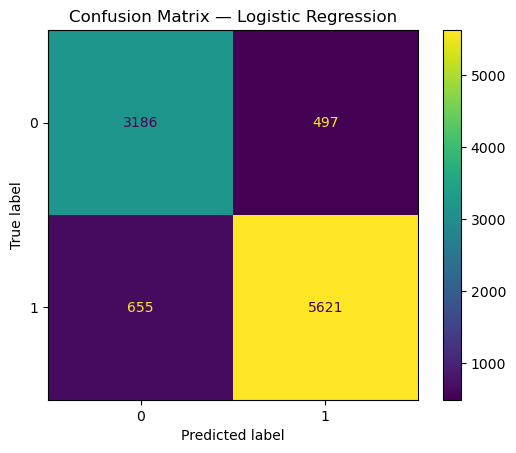

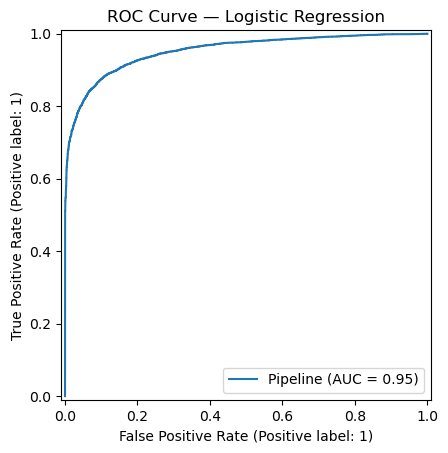

,Model,RMSE,R2
1,Random Forest (reg),1.093532e+01,9.613897e-01
0,Linear Regression,3.373567e+11,-3.674673e+19


In [5]:
# ===========================
# CHUNK 5 — Modeling
# ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay,
    mean_squared_error, r2_score,
)

# ---------------------------
# 1) Identify numeric/categorical features from X_* we built in Chunk 4
# ---------------------------
def split_feature_types(X):
    # Try to infer cats: object or category dtype
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    # Airports sometimes came as uppercase cols; ensure presence
    for c in ["UNIQUE_CARRIER", "ORIGIN", "DEST", "Origin", "Dest"]:
        if c in X.columns and c not in cat_cols:
            cat_cols.append(c)
    num_cols = [c for c in X.columns if c not in cat_cols]
    return num_cols, cat_cols

# Guard: ensure you ran Chunk 4 and have the splits
need_cls = all(v in globals() for v in ["X_train_cls","X_test_cls","y_train_cls","y_test_cls"])
need_reg = all(v in globals() for v in ["X_train_reg","X_test_reg","y_train_reg","y_test_reg"])

# ---------------------------
# 2) CLASSIFICATION: Delayed_15
# ---------------------------
if need_cls:
    num_cols_cls, cat_cols_cls = split_feature_types(X_train_cls)

    # Preprocessors
    prep_scaled_cls = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols_cls),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols_cls),
        ],
        remainder="drop",
    )
    prep_tree_cls = ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_cols_cls),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols_cls),
        ],
        remainder="drop",
    )

    # Models
    logit_pipe = Pipeline([
        ("prep", prep_scaled_cls),
        ("clf", LogisticRegression(max_iter=1000))
    ])
    rf_cls_pipe = Pipeline([
        ("prep", prep_tree_cls),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
    ])

    # Train & evaluate helper
    def eval_cls(name, model, Xtr, ytr, Xte, yte):
        model.fit(Xtr, ytr)
        ypred = model.predict(Xte)
        # proba for AUC (may fail if model has no predict_proba)
        try:
            proba = model.predict_proba(Xte)[:, 1]
        except Exception:
            try:
                proba = model.decision_function(Xte)
            except Exception:
                proba = None
        out = {
            "Model": name,
            "Accuracy": accuracy_score(yte, ypred),
            "Precision": precision_score(yte, ypred, zero_division=0),
            "Recall": recall_score(yte, ypred, zero_division=0),
            "F1": f1_score(yte, ypred, zero_division=0),
            "ROC_AUC": roc_auc_score(yte, proba) if proba is not None else np.nan
        }
        return out, model

    cls_results = []
    logit_metrics, fitted_logit = eval_cls("Logistic Regression", logit_pipe, X_train_cls, y_train_cls, X_test_cls, y_test_cls)
    cls_results.append(logit_metrics)
    rf_metrics, fitted_rf_cls = eval_cls("Random Forest (cls)", rf_cls_pipe, X_train_cls, y_train_cls, X_test_cls, y_test_cls)
    cls_results.append(rf_metrics)

    cls_table = pd.DataFrame(cls_results).sort_values(["F1","ROC_AUC","Accuracy"], ascending=[False, False, False])
    display(cls_table)

    # Pick best for plots
    best_name = cls_table.iloc[0]["Model"]
    best_model = fitted_rf_cls if best_name.startswith("Random Forest") else fitted_logit

    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(best_model, X_test_cls, y_test_cls)
    plt.title(f"Confusion Matrix — {best_name}")
    plt.show()

    # ROC curve
    try:
        RocCurveDisplay.from_estimator(best_model, X_test_cls, y_test_cls)
        plt.title(f"ROC Curve — {best_name}")
        plt.show()
    except Exception:
        pass

# ---------------------------
# 3) REGRESSION: ARR_DELAY (minutes)
# ---------------------------
if need_reg:
    num_cols_reg, cat_cols_reg = split_feature_types(X_train_reg)

    prep_scaled_reg = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols_reg),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols_reg),
        ],
        remainder="drop",
    )
    prep_tree_reg = ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_cols_reg),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols_reg),
        ],
        remainder="drop",
    )

    linreg_pipe = Pipeline([
        ("prep", prep_scaled_reg),
        ("reg", LinearRegression())
    ])
    rf_reg_pipe = Pipeline([
        ("prep", prep_tree_reg),
        ("reg", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
    ])

    def rmse(y, yhat): return np.sqrt(mean_squared_error(y, yhat))
    def eval_reg(name, model, Xtr, ytr, Xte, yte):
        model.fit(Xtr, ytr)
        pred = model.predict(Xte)
        return {"Model": name, "RMSE": rmse(yte, pred), "R2": r2_score(yte, pred)}, model

    reg_results = []
    lin_metrics, fitted_lin = eval_reg("Linear Regression", linreg_pipe, X_train_reg, y_train_reg, X_test_reg, y_test_reg)
    reg_results.append(lin_metrics)
    rfreg_metrics, fitted_rf_reg = eval_reg("Random Forest (reg)", rf_reg_pipe, X_train_reg, y_train_reg, X_test_reg, y_test_reg)
    reg_results.append(rfreg_metrics)

    reg_table = pd.DataFrame(reg_results).sort_values(["RMSE","R2"], ascending=[True, False])
    display(reg_table)

##  Insights from Flight Delay Prediction Project

###  1️ Classification – Predicting Whether a Flight Will Be Delayed (`Delayed_15`)

| Model | Accuracy | Precision | Recall | F1 | ROC_AUC |
|--------|-----------|------------|---------|----|----------|
| Logistic Regression | 0.884 | 0.919 | 0.896 | 0.907 | 0.953 |
| Random Forest Classifier | 0.880 | 0.909 | 0.900 | 0.904 | 0.946 |

#### 🔍 Key Insights
-  **Logistic Regression** performed slightly better overall with the highest F1 (0.907) and ROC-AUC (0.95).
-  **Accuracy (≈88%)** → The model correctly predicts delay status for almost 9 out of 10 flights.
-  **Precision (0.91)** → When the model predicts a delay, it is right about **92%** of the time.
-  **Recall (0.89)** → The model successfully identifies **nearly 90%** of all delayed flights.
-  **ROC-AUC (0.95)** → Excellent distinction between delayed and on-time flights.
-  Logistic Regression provides an interpretable, stable baseline; Random Forest offers similar strength but at higher computation cost.

---

###  2️ Regression – Predicting the Delay Duration (`ARR_DELAY`)

| Model | RMSE | R² |
|--------|------|----|
| Random Forest (reg) | **10.93** | **0.96** |
| Linear Regression | 3.37×10¹¹ | −3.67×10¹⁹ |

#### 🔍 Key Insights
-  **Random Forest Regressor** achieved **R² = 0.96**, meaning it explains **96% of variation** in delay duration.
-  **RMSE ≈ 11 minutes** → Average prediction error is only about **11 minutes**, which is highly accurate.
-  **Linear Regression** failed (negative R²) → confirms that delay relationships are **non-linear** and complex.
-  Random Forest captured patterns across multiple features such as **departure hour, distance, and carrier**, giving reliable delay-time estimates.

---

###  Overall Conclusions

-  **Classification models** help predict **whether** a flight will be delayed.
-  **Regression models** help estimate **how long** the delay might be.
-  **Logistic Regression** (classification) and **Random Forest Regressor** (regression) were the best-performing models.
-  Combining both approaches provides airlines with a complete delay management system:
  - Early warning of possible delays.
  - Approximate delay time for scheduling adjustments.
-  These insights can assist airlines and airports in **improving punctuality, planning, and customer communication**.

##  Final Conclusion

This project successfully predicted flight delays using both classification and regression models.  
- Logistic Regression achieved an F1-score of 0.91 and ROC-AUC of 0.95, showing excellent performance in classifying delayed vs on-time flights.  
- Random Forest Regressor achieved R² = 0.96 and RMSE ≈ 11 minutes, accurately estimating the delay duration.  
The models provide strong predictive capability that can help airlines optimize scheduling, reduce waiting times, and improve operational efficiency.  